# 05 Reinforcement Learning Tutorial
 > # Q-Learning
 >__Created__:  December 2020 Harrison B. Prosper<p>
 > Inspired by Manuel Amunategui's example at:<p> 
 https://amunategui.github.io/reinforcement-learning

## Introduction
In this tutorial the goal is have an agent find an optimal path through a mountainous terrain by following a policy whose quality, quantified as an $expected$ reward, is defined by a function $Q$. The reinforcement learning algorithm that yields an estimate of the $Q$-function is called $Q$-learning. The environment, in this example, is represented by the triple $(x, y, z)$, where $(x, y)$ is the position in the terrain and $z(x, y)$ is the height of the terrain at the specified point. However, we also use the term environment in its usual, non-technical, sense.
     
## $Q$-Learning
Reinforcement learning is a class of algorithms for learning optimal strategies, that is, $(state, action)$ pairs, through trial and error guided by current and estimated future expected rewards. A path (or history) is a sequence of states, while an action moves the environment from one state to another. Optimal in the context of $Q$-learning means that the chosen path yields the maximum expected reward. This class of algorithms is particularly well suited for activities that can be construed as games with well-defined rules. Here we review the basics of the simplest $Q$-learning algorithm.

### Definitions
  1. __environment__: a configuration of objects. The objects could be, for example, pixels in an image.
  1. __state__: a set of attributes, $s$, that characterize the environment at a given time $t$. This could be, for example, the values of the pixels.
  1. __action__: a manipulation of the environment that causes it to transition to another state. Abstractly, an action, $a$, is the mapping $a: s \rightarrow s^\prime$, where $s$ is the current state and $s^\prime$ is the state to which the environment transitions. The mapping 
  can be modeled as a tuple: $(s, s^\prime)$.
  1. __reward__: the $immediate$ reward $R(s, a)$ associated with the action $a: s \rightarrow s^\prime$.
  1. __agent__: an automaton, e.g., a bot, that can take actions that cause the environment to transition from one state to another.
  1. __policy__: a method for choosing an action, $a$, in a given state, $s$. 
  1. __target state__: the desired state, $s^*$, to be reached by executing a sequence of actions determined by a policy.
  1. __Q-function__: the quality, or $expected$ reward, $Q(s, a)$ associated with action $a$ in state $s$. This is the function to be estimated by the training algorithm and the basis of the policy to be followed.
 
A transition from the one state to another may depend on previous states. However, the Q-learning algorithm assumes the Markov property:  *the transition from one state to another depends only on the current state*. The following rule [1],  called the __Temporal Difference Update__,

\begin{align}
    Q(s, a) & \leftarrow (1 - \alpha) Q(s, a)  + \alpha [R(s, a) + \gamma \max_{a^\prime}Q(s^\prime, a^\prime)] ,
\end{align}

has been shown to converge [2] to a function $Q^*(s, a)$ that maximizes the expected reward from state $s$ to the target state, $s^*$. The quantities $$0 < \alpha \leq 1 \textrm{ and } 0 < \gamma < 1$$ are hyperparameters. The hyperparameter $\alpha$ determines how much of the future expected reward is to be taken into account during training relative to the current expected reward, while $\gamma$ is the amount by which a future expected reward is to be discounted relative to the immediate reward $R$.
     
Given that an action $a: s \rightarrow s^\prime$ maps an input state $s$ to an output state $s^\prime$, the update rule can be expressed entirely in terms of states as follows
     
\begin{align}
    Q(s, s^\prime) & = Q(s, s^\prime)  + \alpha [R(s, s^\prime) + \gamma \max_{s^{\prime\prime}}Q(s^\prime, s^{\prime\prime}) - Q(s, s^\prime)] .
\end{align}
Indeed, in this tutorial, the $Q$-function is a direct implementation of the map $a: s \rightarrow s^\prime \in S$, which is modeled as a Python map from state $s$ to its nearest neighbor states $S$, implemented as a list of states.
     
### References
  1. Christopher J.C.H Watkins, *Learning from delayed rewards*, PhD Thesis, University of Cambridge, England (1989).
  1. Christopher J.C.H. Watkins and Peter Dayan, *Technical Note $Q$-Learning*, Machine Learning, __8__, 279-292 (1992).

In [1]:
# standard modules
import os, sys, time
import numpy as np
import scipy.stats as st 
import matplotlib as mp
import matplotlib.pyplot as plt
import imageio as im

# a nice module to handle graphs (in this context, a graph 
# is a network of nodes with directed edges between them).
# to install the module do
#   conda install networkx
# within your miniconda3 environment
import networkx as nx

# draw graphs inline
%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

mp.rc('text', usetex=False)

### Define available states and actions 
The states form a 2-D grid of points, while actions are edges between points. 

Create nodes

For a square grid, the number of nodes is $n^2$, where $n$ is the number of points in the $x$ and $y$ directions.

In [3]:
# ---------------------------------------------
# size of grid
# ---------------------------------------------
rmax = 25
N    = rmax + 1 # number of points in x and y
xmin, xmax = 0, rmax
ymin, ymax = 0, rmax
x_limits   = (xmin, xmax)
y_limits   = (ymin, ymax)
# ---------------------------------------------
# create all possible nodes
# ---------------------------------------------
xx     = np.arange(xmin, xmax+1, 1)
yy     = np.arange(ymin, ymax+1, 1)
mxx,myy= np.meshgrid(xx, yy)
# convert meshgrid into a set of tuples (x, y)
nodes  = [(x, y) for x, y in zip(mxx.flatten(), 
                                 myy.flatten())]
nodes = set(nodes)
print('number of nodes: %d' % len(nodes), N*N)

number of nodes: 676 676


### Landscape

Create a mountainous terrain with a maximum height of one unit.

#### Algorithm
 1. choose at random a position, $\mu_k = (\mu_x, \mu_y)_k$, in the 2-D plane
 1. choose at random a height, $h_k$
 1. choose at random a (diagonal) covariance matrix, $\Sigma_k$.
 1. repeat 1 - 3 $K$ times
 1. compute height of terrain at location $\mathbf{x} = (x, y)$ as: $h(\mathbf{x}) = \sum_{k=1}^K h_k \, N(\mathbf{x}, \mu_k, \Sigma_k)\,/\,N(\mu_k, \mu_k, \Sigma_k)$; 
 $h(\mathbf{x}) = h(\mathbf{x}) \, / \max_\mathbf{x} h(\mathbf{x})$.

In [4]:
class Landscape:
    def __init__(self,
                 xlimits=x_limits, 
                 ylimits=y_limits,
                 npeaks=500,
                 stdv_min=0.5,
                 stdv_max=5.0):
        
        # choose parameters of multivariate Gaussians
        self.xmin, self.xmax = xlimits
        self.ymin, self.ymax = ylimits
        self.mu    = []    # position of peaks
        self.scale = []    # height of peaks
        self.cov   = []    # width of peaks
        
        # make mountainous region extend a bit
        # beyond display.
        x_min, x_max = xlimits        
        y_min, y_max = ylimits
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_max += 0.2*x_range
        y_max += 0.2*y_range
        x_min -= 0.2*x_range
        y_min -= 0.2*x_range
        
        for ii in range(npeaks):
            x_mu = rnd.uniform(x_min, x_max)
            y_mu = rnd.uniform(y_min, y_max)
            if (x_mu > 0.8 * xlimits[1]) and \
               (y_mu > 0.8 * ylimits[1]): continue
                
            self.mu.append(np.array([x_mu, y_mu]))
            self.scale.append(rnd.uniform())
            if rnd.uniform() < 0.6:
                stdv = rnd.uniform(stdv_min, stdv_max)
            else:
                stdv = rnd.uniform(stdv_min/5, stdv_min)
            self.cov.append(np.array([[stdv, 0.0], [ 0.0, stdv]]))
            
    def __call__(self, pos=None, nn=101):
        
        # create a list of positions
        if pos == None:
            # create a meshgrid
            xstep = (self.xmax-self.xmin) / (nn-1)
            ystep = (self.ymax-self.ymin) / (nn-1)
            xx    = np.arange(xmin, xmax+xstep, xstep)
            yy    = np.arange(ymin, ymax+ystep, ystep)
            xx,yy = np.meshgrid(xx, yy)
            # convert meshgrid into a set of tuples (x, y)
            xy = [(x, y) for x, y in zip(xx.flatten(), yy.flatten())]
        else:
            xy = pos
            
        # compute height at each point
        xy = np.array(xy)
        zz = np.zeros(len(xy))
        for h, m, c in zip(self.scale, self.mu, self.cov):
            zmax= st.multivariate_normal.pdf(m, m, c)
            z   = st.multivariate_normal.pdf(xy, m, c) / zmax
            zz += h * z
        zz = zz / np.max(zz)
        
        if pos == None:
            # reshape if zz is to be used to plot contours.
            zz = zz.reshape(nn,nn)
            return (xx, yy, zz)
        else:
            return zz
            
    def __del__(self):
        pass

Create edges

For a square grid, the number of edges is $2 (n^2 - n)$. 

There are $n^2$ nodes with $n$ along the diagonal of the grid. The number of points excluding those on the diagonal is, therefore, $n^2 - n$. If we attach 2 edges to each of these points, one up and the other to the right for the points below the diagonal and one down and the other to the left for the points above the diagonal we arrive at the total number of edges, $2(n^2 - n)$.

In [5]:
edges = []
for pos in nodes:
    x, y  = pos
    
    # go up one unit
    u_pos = (x, y+1)
    if u_pos in nodes:
        edges.append((pos, u_pos))
        
    # go right one unit
    r_pos = (x+1, y)
    if r_pos in nodes:
        edges.append((pos, r_pos))

# create graph from the edges
graph = nx.Graph()
graph.add_edges_from(edges)
print('number of edges: %5d' % len(edges), 2*(N**2-N))

number of edges:  1300 1300


### Plot graph
Plot the graph with the nodes placed as requested and an optional path.

In [6]:
def plot_graph(graph,    # a network of nodes
               terrain,
               filename=None,
               paths=[], # paths defined by ordered sequences of nodes
               target=None,
               xlimits=x_limits, 
               ylimits=y_limits,
               latex=False):
    
    # set to latex to True if you have a
    # fully functional latex system on
    # your machine and you want publication
    # quality fonts.
    mp.rc('text', usetex=latex)

    # set up an empty figure
    fig = plt.figure(figsize=(6, 6))
    ax  = fig.add_subplot(1, 1, 1)
        
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$y$', fontsize=14)
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)
    
    if target != None:
        x, y = target
        ax.scatter([x],[y], s=80, c='k')
        
    if len(paths) > 0:
        kolors = ['red', 'orange', 'yellow', 'cyan', 'blue', 'magenta']
        ii = 0
        for path in paths:
            # plot paths
            x = [z for z, _ in path]
            y = [z for _, z in path]
            ax.plot(x, y, c=kolors[ii], linewidth=3)
            ii += 1
            if ii >= len(kolors):
                ii = 0

    # plot terrain
    xx, yy, zz = terrain
    
    # get a fancy color map
    #mycmap = plt.get_cmap('gist_earth')
    mycmap = plt.get_cmap('summer') 
    #plt.imshow(zz, origin='lower', aspect='auto', 
    #           extent=(xmin, xmax, ymin, ymax), 
    #           cmap=mycmap)
    #plt.colorbar()
    
    # plot contours
    step = 0.01
    mylevels = np.arange(0, 1, step)
    ax.contour(xx, yy, zz, levels=mylevels, cmap=mycmap)   
    
    # in order to place the nodes where we
    # want them, draw_networkx requires the
    # positions to be given in a node to 
    # position map.
    nodes = {}
    for node in graph:
        nodes[node] = node
        
    # finally, draw the network of connected
    # nodes, that is, the graph!
    nx.draw_networkx(graph, 
                     pos=nodes,
                     node_color='orange',
                     node_size=2,
                     edge_color='green',
                     with_labels=False,
                     width=1,
                     font_size=7,
                     ax=ax)
    
    # apparently, this is needed to make
    # the axes appear!
    ax.tick_params(left=True, 
                   bottom=True, 
                   labelleft=True, 
                   labelbottom=True)
    fig.tight_layout()
    
    if filename != None:
        plt.savefig(filename)
        
    plt.show()

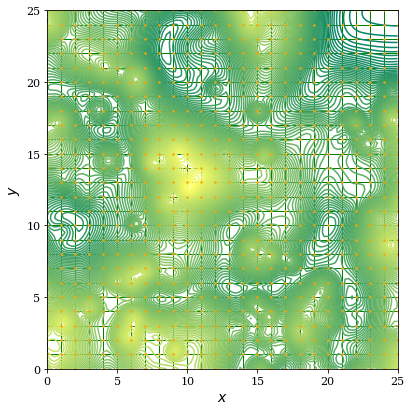

In [7]:
landscape = Landscape()
terrain   = landscape()
plot_graph(graph, terrain)

### Target state
Based on the image above, choose target state.

In [8]:
target_state = (25, 25)

### Model environment
The states of the environment, itself modeled by the class *Environment*, are modeled as tuples $(x, y)$ with different values for the attributes $x$ and $y$. An action, $a$, is a mapping $a: (x, y) \rightarrow (x^\prime, y^\prime)$. The environment class has several methods, including *neighbors$(s)$* which returns, in a list, the nearest neighbor states connected to state $s$. Given the pair $(s, a)$, the environment returns the value of the immediate award $R(s, a)$ as well as the next state of the environment $s^\prime$. Since, in this example, $R(s, a)$ depends on $s^*$, the environment needs to be made aware of the desired target state $s^*$.

In this example, the immediate reward function is chosen to be

\begin{align}
R(s, a) & = \begin{cases}
                r_\max &  \text{if } s^\prime = s^* \\
                r_\max [h(s) - h(s^\prime)]\,/\, f & \text{otherwise}, 
            \end{cases}
\end{align}

where $f > 1$ and $h$ is the height of the terrain at any given position (that is, state), where the height of the highest peak is 1 unit. The factor $f$ should be chosen so that the immediate reward, $r_\max$, for transitioning to the target state $s^*$ is much larger than the maximum immediate reward for any other transition. The above reward function penalizes transitions that involve climbing, are neutral about ones that maintain the height of the path, and favor transitions that decrease the height of the path.  

A possible issue with such a reward function is that it may cause the agent to get stuck in a high mountain valley. 

In [9]:
class Environment:
    '''
 Help on class Environment:

 class Environment
  |  Environment(graph)
  |
  |  Model an environment whose states are modeled by tuples (x, y),
  |  where x and y are non-negative integers.
  |
  |  Parameters
  |  ----------
  |  graph         : graph defining the set of environment histories.
  |  rmax          : maximum immediate reward (default=1.0)
  |  f             : factor by which other reward "r" is smaller than
  |                  rmax (default=20)
    '''
    def __init__(self, graph, landscape, rmax=1.0, f=20):
        
        self.graph  = graph
        # map positions (nodes) to heights
        h           = landscape(pos=self.states())
        self.h      = {}
        for i, state in enumerate(self.states()):
            self.h[state] = h[i]
            
        self.target = None # target state
        self.state  = None # current state
        self.rmax   = rmax # maximum reward for transition to target state
        self.r      = rmax / f # maximum reward otherwise
        self.f      = f
        
    def __del__(self):
        pass
    
    def __len__(self):
        return self.number_of_states()
    
    def number_of_states(self):
        return len(self.graph)
    
    def number_of_actions(self):
        return len(self.graph.edges)
        
    def current_state(self):
        return self.state
    
    def target_state(self):
        return self.target
           
    def max_reward(self):
        return self.rmax
    
    def states(self):
        return list(self.graph)
         
    def actions(self):
        return list(self.graph.edges)
    
    def neighbors(self, state):
        # implement map a: s => s_prime in S
        if state in self.graph:
            return list(self.graph[state])
        else:
            return None
        
    def set_target_state(self, target_state):
        self.target = target_state
    
    # implement action a: state => next_state
    def step(self, state, action):
        self.state = state
        
        # make sure we have a valid (state, action) pair
        states = self.neighbors(state)
        if states == None:        return (state, 0)
        if action <  0:           return (state, 0)
        if action >= len(states): return (state, 0)
        
        # for now, assume a deterministic transition 
        # to next state. in future, we could implement
        # an epsilon transition policy:
        #   with probability 1-epsilon move to state 
        #   determined by action else move to a valid
        #   but randomly selected state
        next_state = states[action]
        
        # compute immediate reward

        if next_state == self.target:
            r = self.rmax
        else:
            # height of terrain at current location (state)
            h_state = self.h[state]
            
            # height of terrain at next location (next_state)
            h_next_state = self.h[next_state]
            
            # compute immediate reward
            r = h_state - h_next_state
            
        self.state = next_state
        
        return (next_state, r)

### Model $Q(s, a)$ function

Trained using: 

\begin{align}
    Q(s, a) & \leftarrow (1 - \alpha) Q(s, a)  + \alpha [R(s, a) + \gamma \max_{a^\prime}Q(s^\prime, a^\prime)] .
\end{align}

In [10]:
class Qfunction:    
    def __init__(self, env, 
                 gamma=0.9, alpha=1.0, epsilon=1.0, depsilon=0.0):
        
        # cache inputs, including the environment
        self.env      = env             
        self.gamma    = gamma
        self.alpha    = alpha
        self.epsilon  = epsilon
        self.depsilon = depsilon
        self.p        = 1 - epsilon
        self.max_R    = env.max_reward()
        self.sum_Q    = 0.0
        self.max_Q    = 0.0
        
        # initialize scores and Q function
        self.reset()

    def __del__(self):
        pass
    
    def __call__(self, state, action):
        Q = self.Q
        if state not in Q:
            return -1
        if action < 0:
            return -2
        if action >= len(Q[state]):
            return -3
        return Q[state][action]
    
    def __str__(self):
        Q      = self.Q
        env    = self.env
        states = list(Q.keys())
        states.sort()
        
        s_str = ''
        for i, s in enumerate(states):
            qq = Q[s]
            nn = env.neighbors(s)
            
            x, y = s
            s_str += '%5d (%2d,%2d) =>' % (i,x,y)
            
            for n in nn: s_str += ' (%2d,%2d)' % n
            s_str += '\n%16s' % ''
            
            for q in qq: s_str += ' %6.3f ' % q
            s_str += '\n'
            
        return s_str[:-1]
    
    def reset(self):
        env = self.env
        # initialize scores
        self.scores = []
        # initialize Q function to zero 
        # forall pairs (s, a)
        self.Q = {} # Q values
        for state in env.states():
            self.Q[state] = [0.0]*len(env.neighbors(state))
            
    def update(self, state, action):
        gamma = self.gamma
        alpha = self.alpha
        Q     = self.Q
        env   = self.env
        
        # get next state and reward associated with
        # action a: state => next_state
        next_state, reward = env.step(state, action)
        
        # update Q value
        # note: if alpha = 0.0, the agent learns nothing.
        #       if alpha = 1.0, the agent relies solely on
        #       the current expected reward and not at all 
        #       on prior estimates of the expected reward.
        # gamma < 1 implies that future rewards are discounted
        # relative to immediate rewards and the discount increases
        # geometrically the more distant the future is from the
        # present.
        
        s = state
        a = action
        n = next_state
        
        # for state n, get the action k with the largest Q value
        k = np.argmax(Q[n])
        
        # update Q function
        Q_prev  = Q[s][a]
        
        Q[s][a] = (1 - alpha)*Q[s][a] + alpha*(reward + gamma*Q[n][k])

        Q_new   = Q[s][a]
        
        # update sum(Q)
        self.sum_Q -= Q_prev
        self.sum_Q += Q_new
        # update max(Q)
        if Q_new > self.max_Q: self.max_Q = Q_new
        
        # compute score
        score = self.max_R*self.sum_Q/self.max_Q if self.max_Q > 0 else 0
        return score
    
    def pick_state(self):
        Q = self.Q
        k = rnd.randint(len(Q))
        return list(Q.keys())[k]
    
    def pick_action(self, state):
        Q = self.Q
        if state not in Q: return None
        if len(Q[state]) == 0: return None
        
        # implement epsilon greedy policy:
        #   for the given state, pick with probability 
        #   p = 1 - epsilon the action with the largest Q value 
        #   else pick a random action.
        u = np.random.uniform()
        if u < self.p:
            # pick action with the largest Q value
            a = np.argmax(Q[state])
        else:
            # pick a random action
            a = rnd.randint(len(Q[state]))
        return a
        
    def train(self, target_state, 
              n_iterations=10001, 
              reset_training=False):
        
        # need to tell environment the desired target state 
        # since the immediate reward function 
        # computed by the environment depends on it.
        self.env.set_target_state(target_state)
        
        if reset_training:
            self.reset()
            
        # simulate a random sample of 
        # (state=x, action=a, next_state=y, reward=r)
        # according to the fixed probability function
        # p(x, a, y, r) = p(y|a,x,r)p(a,r|x)p(x)
        for ii in range(n_iterations):
            
            # pick a state at random
            state  = self.pick_state()
            
            # pick action according to an 
            # epsilon-greedy policy
            action = self.pick_action(state)
            
            # update Q function
            score  = self.update(state, action)
            self.scores.append(score)
            
            # print score
            if ii % 1000 == 0:
                print('\r%5d\tscore: %10.2f' % (ii, score), end='')
            
    def set_Q(self, Q):
        self.Q = Q
        
    def get_Q(self):
        return self.Q
    
    def get_path(self, state):
        start = state
        path  = [start]
    
        Q     = self.Q
        env   = self.env
        target= env.target_state()
        max_it= 10 * len(Q)
        
        ii = 0

        while (state != target) and (ii < max_it):
            
            Q_values = np.array(Q[state])
            
            ii += 1

            # choose optimal action
            action = np.argmax(Q_values)
            
            # get the next state using optimal action
            next_state = env.neighbors(state)[action]
            
            # if the next_state is already in the current
            # path, then assume that the agent is lost!
            if next_state in set(path) or next_state == None:
                path = []
                break
            
            # continue building path
            path.append(next_state)
            state = next_state
        return path

In [11]:
def plot_scores(scores): 
    # create an empty figure
    fig = plt.figure(figsize=(8, 4))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_ylim((0, 1.1*max(scores)))
    ax.set_xlim((0, len(scores)))
    
    ax.plot(scores, 'b')
    ax.set_xlabel('iterations', fontsize=16)
    ax.set_ylabel('score', fontsize=16)
    ax.grid(True, which="both", linestyle='-')

    plt.show()

### Now train $Q$!

In [12]:
env = Environment(graph, landscape, f=100)

In [13]:
Q = Qfunction(env, alpha=1.0, gamma=0.95)

200000	score:     890.39

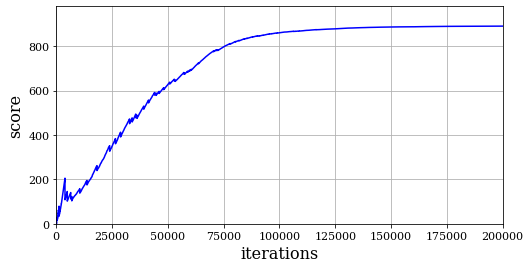

In [14]:
n_iter = 200001
Q.train(target_state, n_iter)
plot_scores(Q.scores)

Determine fraction of sucessful paths. 

In [15]:
pos   = list(nodes)
starts= []
for start in pos:
    if start == target_state: continue    
    path = Q.get_path(start)
    if len(path) == 0: continue
    if path[-1] == target_state:
        starts.append(start)
        
frac = float(len(starts)) / len(nodes)
print('successes: %d; fraction of successful paths: %5.2f' % (len(starts),
      frac))

successes: 675; fraction of successful paths:  1.00


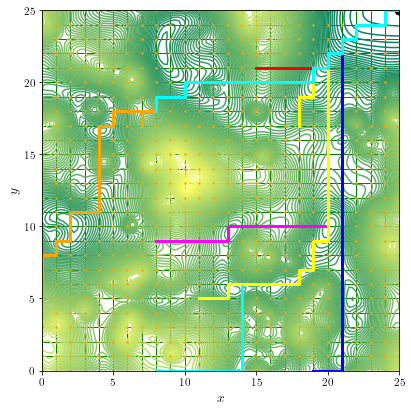

In [16]:
paths = []
ii = 0
for start in starts[:10]:    
    paths.append(Q.get_path(start))
plot_graph(graph, terrain, target=target_state, 
           latex=True, 
           paths=paths, filename='05_terrain.png')